In [1]:
!pip install --upgrade albumentations

     |████████████████████████████████| 102 kB 5.5 MB/s 
     |████████████████████████████████| 47.6 MB 37 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import albumentations as A 
import albumentations.pytorch
from imgaug import augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt 

import cifarmodel
import train 
import test

In [3]:
# loading the dataset
data_set = datasets.CIFAR10('./data', train=True, download=True)
cdata =data_set.data

# Calculate the mean and std for normalization
print('[Train]')
print(' - Numpy Shape:', cdata.shape)
print(' - min:', np.min(cdata, axis=(0,1,2)) / 255.)
print(' - max:', np.max(cdata, axis=(0,1,2)) / 255.)
print(' - mean:', np.mean(cdata, axis=(0,1,2)) / 255.)
print(' - std:', np.std(cdata, axis=(0,1,2)) / 255.)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]


In [4]:
## Data Visualisation

In [5]:
data_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
def viz_data(cols=8, rows=5):
  figure = plt.figure(figsize=(14, 10))
  for i in range(1, cols * rows + 1):
    img, label = data_set[i]

    figure.add_subplot(rows, cols, i)
    plt.title(data_set.classes[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")

  plt.tight_layout()
  plt.show()

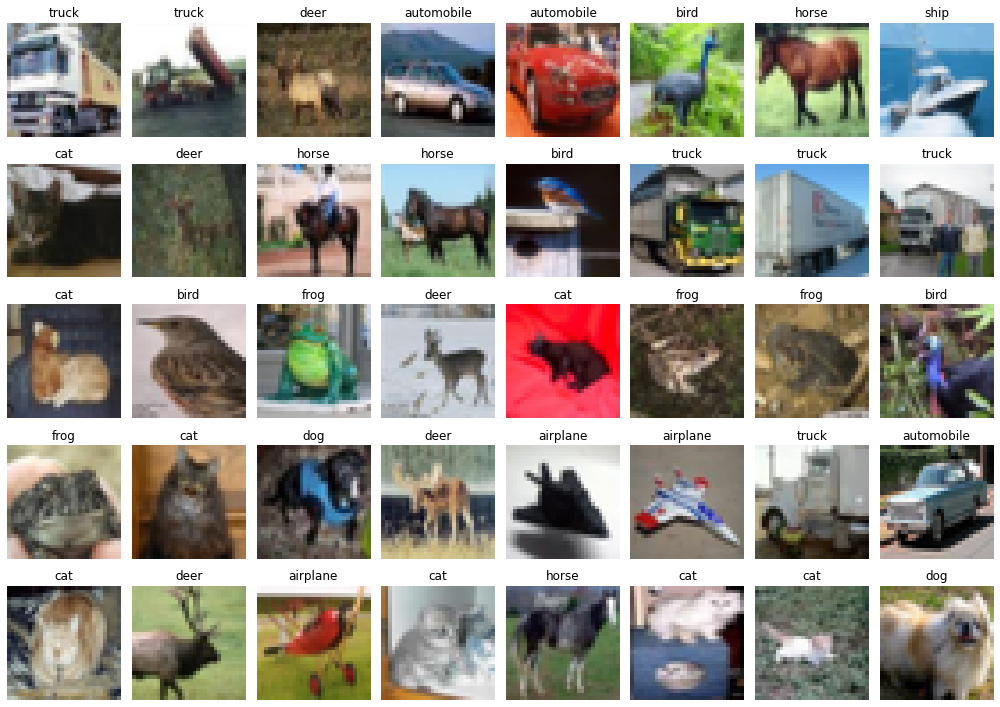

In [7]:
viz_data()

## Data Augmentation

In [8]:
def show_images(aug_dict, ncol=6):
  nrow = len(aug_dict)

  fig, axes = plt.subplots(ncol, nrow, figsize=( 3*nrow, 15), squeeze=False)
  for i, (key, aug) in enumerate(aug_dict.items()):
    for j in range(ncol):
      ax = axes[j,i]
      if j == 0:
        ax.text(0.5, 0.5, key, horizontalalignment='center', verticalalignment='center', fontsize=15)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
      else:
        image, label = data_set[j-1]
        if aug is not None:
          transform = A.Compose([aug])
          image = np.array(image)
          image = transform(image=image)['image']
          
        ax.imshow(image)
        ax.set_title(f'{data_set.classes[label]}')
        ax.axis('off')

  plt.tight_layout()
  plt.show()

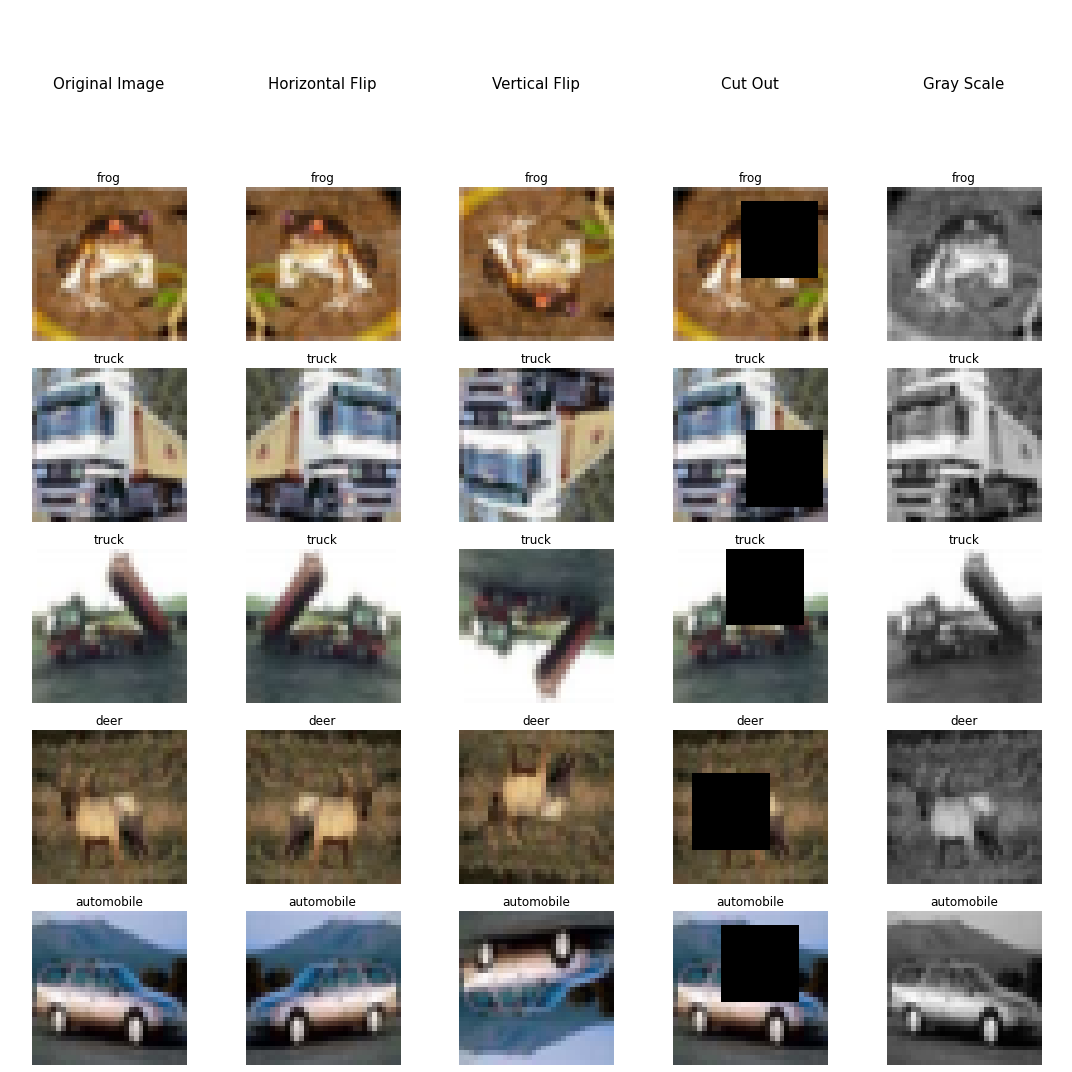

In [9]:
show_images({
    'Original Image': None,
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
                               min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Gray Scale': A.ToGray(always_apply=True)
})

## Defining the albumentations

In [10]:
## # custom dataset class for albumentations library
class AlbumentationImageDataset():
  def __init__(self, image_list, train= True):
      self.image_list = image_list
      self.aug = A.Compose({
          A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
          A.HorizontalFlip(),
          A.ShiftScaleRotate(),
          A.CoarseDropout(1, 16, 16, 1, 16, 16,fill_value=0.473363, mask_fill_value=None),
          A.ToGray()
      })

      self.norm = A.Compose({A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
      })
      self.train = train
        
  def __len__(self):
      return (len(self.image_list))

  def __getitem__(self, i):
      
      image, label = self.image_list[i]
      
      if self.train:
        #apply augmentation only for training
        image = self.aug(image=np.array(image))['image']
      else:
        image = self.norm(image=np.array(image))['image']
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      return torch.tensor(image, dtype=torch.float), label

In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=64
else:
    BATCH_SIZE=64

CUDA Available: True


In [12]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
import cifarmodel

In [14]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = cifarmodel.CNN().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 30, 30]          18,432
      BatchNorm2d-10           [-1, 64, 30, 30]             128
             ReLU-11           [-1, 64, 30, 30]               0
          Dropout-12           [-1, 64, 30, 30]               0
           Conv2d-13           [-1, 64, 16, 16]           4,096
           Conv2d-14           [-1

In [15]:
def fit_model(net, NUM_EPOCHS=20, l1=False, l2=False):
  training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
  
  if l2:
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
  else:
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

  for epoch in range(1,NUM_EPOCHS+1):
      print("EPOCH:", epoch)
      train_acc, train_loss = train.train(net, device, train_loader, optimizer, l1, scheduler)
      test_acc, test_loss = test.test(net, device, test_loader)

      training_acc.append(train_acc)
      training_loss.append(train_loss)
      testing_acc.append(test_acc)
      testing_loss.append(test_loss)
      
  return net, (training_acc, training_loss, testing_acc, testing_loss)

In [16]:
net, history = fit_model(net, NUM_EPOCHS=100)

EPOCH: 1


Batch_id=781 Loss=2.07273 Accuracy=22.05: 100%|██████████| 782/782 [00:43<00:00, 18.00it/s]



Test set: Average loss: 1.7034, Accuracy: 3418/10000 (34.18%)

EPOCH: 2


Batch_id=781 Loss=1.76417 Accuracy=34.17: 100%|██████████| 782/782 [00:43<00:00, 18.07it/s]



Test set: Average loss: 1.4959, Accuracy: 4478/10000 (44.78%)

EPOCH: 3


Batch_id=781 Loss=1.60875 Accuracy=41.04: 100%|██████████| 782/782 [00:43<00:00, 18.07it/s]



Test set: Average loss: 1.3475, Accuracy: 5176/10000 (51.76%)

EPOCH: 4


Batch_id=781 Loss=1.50755 Accuracy=45.23: 100%|██████████| 782/782 [00:43<00:00, 18.17it/s]



Test set: Average loss: 1.2382, Accuracy: 5452/10000 (54.52%)

EPOCH: 5


Batch_id=781 Loss=1.43342 Accuracy=48.17: 100%|██████████| 782/782 [00:43<00:00, 18.12it/s]



Test set: Average loss: 1.1757, Accuracy: 5766/10000 (57.66%)

EPOCH: 6


Batch_id=781 Loss=1.37607 Accuracy=50.32: 100%|██████████| 782/782 [00:43<00:00, 17.99it/s]



Test set: Average loss: 1.0670, Accuracy: 6153/10000 (61.53%)

EPOCH: 7


Batch_id=781 Loss=1.32416 Accuracy=52.57: 100%|██████████| 782/782 [00:43<00:00, 17.97it/s]



Test set: Average loss: 1.0188, Accuracy: 6378/10000 (63.78%)

EPOCH: 8


Batch_id=781 Loss=1.28252 Accuracy=54.13: 100%|██████████| 782/782 [00:43<00:00, 18.09it/s]



Test set: Average loss: 1.0749, Accuracy: 6282/10000 (62.82%)

EPOCH: 9


Batch_id=781 Loss=1.25389 Accuracy=55.48: 100%|██████████| 782/782 [00:42<00:00, 18.40it/s]



Test set: Average loss: 0.9513, Accuracy: 6696/10000 (66.96%)

EPOCH: 10


Batch_id=781 Loss=1.21153 Accuracy=57.11: 100%|██████████| 782/782 [00:42<00:00, 18.22it/s]



Test set: Average loss: 0.9642, Accuracy: 6745/10000 (67.45%)

EPOCH: 11


Batch_id=781 Loss=1.18086 Accuracy=58.35: 100%|██████████| 782/782 [00:42<00:00, 18.22it/s]



Test set: Average loss: 0.9270, Accuracy: 6823/10000 (68.23%)

EPOCH: 12


Batch_id=781 Loss=1.15521 Accuracy=59.18: 100%|██████████| 782/782 [00:42<00:00, 18.41it/s]



Test set: Average loss: 0.7913, Accuracy: 7203/10000 (72.03%)

EPOCH: 13


Batch_id=781 Loss=1.12629 Accuracy=60.43: 100%|██████████| 782/782 [00:42<00:00, 18.42it/s]



Test set: Average loss: 0.7957, Accuracy: 7281/10000 (72.81%)

EPOCH: 14


Batch_id=781 Loss=1.10786 Accuracy=61.20: 100%|██████████| 782/782 [00:42<00:00, 18.32it/s]



Test set: Average loss: 0.7822, Accuracy: 7329/10000 (73.29%)

EPOCH: 15


Batch_id=781 Loss=1.09359 Accuracy=61.83: 100%|██████████| 782/782 [00:43<00:00, 18.18it/s]



Test set: Average loss: 0.8109, Accuracy: 7133/10000 (71.33%)

EPOCH: 16


Batch_id=781 Loss=1.06609 Accuracy=62.74: 100%|██████████| 782/782 [00:42<00:00, 18.34it/s]



Test set: Average loss: 0.8377, Accuracy: 7121/10000 (71.21%)

EPOCH: 17


Batch_id=781 Loss=1.05237 Accuracy=63.25: 100%|██████████| 782/782 [00:42<00:00, 18.31it/s]



Test set: Average loss: 0.7401, Accuracy: 7466/10000 (74.66%)

EPOCH: 18


Batch_id=781 Loss=1.03018 Accuracy=63.86: 100%|██████████| 782/782 [00:42<00:00, 18.37it/s]



Test set: Average loss: 0.6814, Accuracy: 7645/10000 (76.45%)

EPOCH: 19


Batch_id=781 Loss=1.01807 Accuracy=64.57: 100%|██████████| 782/782 [00:42<00:00, 18.32it/s]



Test set: Average loss: 0.6819, Accuracy: 7593/10000 (75.93%)

EPOCH: 20


Batch_id=781 Loss=1.00659 Accuracy=64.91: 100%|██████████| 782/782 [00:42<00:00, 18.44it/s]



Test set: Average loss: 0.6611, Accuracy: 7721/10000 (77.21%)

EPOCH: 21


Batch_id=781 Loss=0.99487 Accuracy=65.22: 100%|██████████| 782/782 [00:42<00:00, 18.48it/s]



Test set: Average loss: 0.6541, Accuracy: 7775/10000 (77.75%)

EPOCH: 22


Batch_id=781 Loss=0.97987 Accuracy=65.79: 100%|██████████| 782/782 [00:42<00:00, 18.33it/s]



Test set: Average loss: 0.6665, Accuracy: 7709/10000 (77.09%)

EPOCH: 23


Batch_id=781 Loss=0.96487 Accuracy=66.28: 100%|██████████| 782/782 [00:42<00:00, 18.24it/s]



Test set: Average loss: 0.6359, Accuracy: 7800/10000 (78.00%)

EPOCH: 24


Batch_id=781 Loss=0.95943 Accuracy=66.44: 100%|██████████| 782/782 [00:43<00:00, 17.79it/s]



Test set: Average loss: 0.6393, Accuracy: 7809/10000 (78.09%)

EPOCH: 25


Batch_id=781 Loss=0.95065 Accuracy=66.74: 100%|██████████| 782/782 [00:44<00:00, 17.69it/s]



Test set: Average loss: 0.6442, Accuracy: 7814/10000 (78.14%)

EPOCH: 26


Batch_id=781 Loss=0.93982 Accuracy=67.20: 100%|██████████| 782/782 [00:43<00:00, 17.87it/s]



Test set: Average loss: 0.6264, Accuracy: 7817/10000 (78.17%)

EPOCH: 27


Batch_id=781 Loss=0.93582 Accuracy=67.24: 100%|██████████| 782/782 [00:44<00:00, 17.64it/s]



Test set: Average loss: 0.6359, Accuracy: 7829/10000 (78.29%)

EPOCH: 28


Batch_id=781 Loss=0.92191 Accuracy=67.79: 100%|██████████| 782/782 [00:43<00:00, 17.81it/s]



Test set: Average loss: 0.6522, Accuracy: 7789/10000 (77.89%)

EPOCH: 29


Batch_id=781 Loss=0.91484 Accuracy=67.90: 100%|██████████| 782/782 [00:44<00:00, 17.75it/s]



Test set: Average loss: 0.5816, Accuracy: 8001/10000 (80.01%)

EPOCH: 30


Batch_id=781 Loss=0.91400 Accuracy=68.19: 100%|██████████| 782/782 [00:44<00:00, 17.67it/s]



Test set: Average loss: 0.6648, Accuracy: 7697/10000 (76.97%)

EPOCH: 31


Batch_id=781 Loss=0.90378 Accuracy=68.42: 100%|██████████| 782/782 [00:44<00:00, 17.69it/s]



Test set: Average loss: 0.6008, Accuracy: 7912/10000 (79.12%)

EPOCH: 32


Batch_id=781 Loss=0.89930 Accuracy=68.52: 100%|██████████| 782/782 [00:44<00:00, 17.66it/s]



Test set: Average loss: 0.6168, Accuracy: 7878/10000 (78.78%)

EPOCH: 33


Batch_id=781 Loss=0.89154 Accuracy=68.72: 100%|██████████| 782/782 [00:44<00:00, 17.69it/s]



Test set: Average loss: 0.5787, Accuracy: 8027/10000 (80.27%)

EPOCH: 34


Batch_id=781 Loss=0.88320 Accuracy=69.12: 100%|██████████| 782/782 [00:43<00:00, 17.80it/s]



Test set: Average loss: 0.6067, Accuracy: 7951/10000 (79.51%)

EPOCH: 35


Batch_id=781 Loss=0.87239 Accuracy=69.64: 100%|██████████| 782/782 [00:43<00:00, 17.86it/s]



Test set: Average loss: 0.6025, Accuracy: 7958/10000 (79.58%)

EPOCH: 36


Batch_id=781 Loss=0.86726 Accuracy=69.61: 100%|██████████| 782/782 [00:44<00:00, 17.70it/s]



Test set: Average loss: 0.5972, Accuracy: 7994/10000 (79.94%)

EPOCH: 37


Batch_id=781 Loss=0.86876 Accuracy=69.63: 100%|██████████| 782/782 [00:43<00:00, 17.80it/s]



Test set: Average loss: 0.5384, Accuracy: 8141/10000 (81.41%)

EPOCH: 38


Batch_id=781 Loss=0.85940 Accuracy=70.00: 100%|██████████| 782/782 [00:44<00:00, 17.75it/s]



Test set: Average loss: 0.5609, Accuracy: 8081/10000 (80.81%)

EPOCH: 39


Batch_id=781 Loss=0.86170 Accuracy=69.84: 100%|██████████| 782/782 [00:44<00:00, 17.77it/s]



Test set: Average loss: 0.5463, Accuracy: 8134/10000 (81.34%)

EPOCH: 40


Batch_id=781 Loss=0.85370 Accuracy=70.39: 100%|██████████| 782/782 [00:44<00:00, 17.54it/s]



Test set: Average loss: 0.5479, Accuracy: 8108/10000 (81.08%)

EPOCH: 41


Batch_id=781 Loss=0.84444 Accuracy=70.29: 100%|██████████| 782/782 [00:44<00:00, 17.64it/s]



Test set: Average loss: 0.5325, Accuracy: 8171/10000 (81.71%)

EPOCH: 42


Batch_id=781 Loss=0.84578 Accuracy=70.52: 100%|██████████| 782/782 [00:44<00:00, 17.62it/s]



Test set: Average loss: 0.5343, Accuracy: 8207/10000 (82.07%)

EPOCH: 43


Batch_id=781 Loss=0.83972 Accuracy=70.68: 100%|██████████| 782/782 [00:44<00:00, 17.73it/s]



Test set: Average loss: 0.5130, Accuracy: 8202/10000 (82.02%)

EPOCH: 44


Batch_id=781 Loss=0.83169 Accuracy=71.07: 100%|██████████| 782/782 [00:44<00:00, 17.66it/s]



Test set: Average loss: 0.5618, Accuracy: 8099/10000 (80.99%)

EPOCH: 45


Batch_id=781 Loss=0.83312 Accuracy=70.91: 100%|██████████| 782/782 [00:44<00:00, 17.62it/s]



Test set: Average loss: 0.5304, Accuracy: 8190/10000 (81.90%)

EPOCH: 46


Batch_id=781 Loss=0.82027 Accuracy=71.26: 100%|██████████| 782/782 [00:44<00:00, 17.59it/s]



Test set: Average loss: 0.5389, Accuracy: 8175/10000 (81.75%)

EPOCH: 47


Batch_id=781 Loss=0.82378 Accuracy=71.35: 100%|██████████| 782/782 [00:44<00:00, 17.60it/s]



Test set: Average loss: 0.5039, Accuracy: 8263/10000 (82.63%)

EPOCH: 48


Batch_id=781 Loss=0.81949 Accuracy=71.39: 100%|██████████| 782/782 [00:44<00:00, 17.63it/s]



Test set: Average loss: 0.5014, Accuracy: 8285/10000 (82.85%)

EPOCH: 49


Batch_id=781 Loss=0.81331 Accuracy=71.65: 100%|██████████| 782/782 [00:44<00:00, 17.56it/s]



Test set: Average loss: 0.5112, Accuracy: 8275/10000 (82.75%)

EPOCH: 50


Batch_id=781 Loss=0.81600 Accuracy=71.46: 100%|██████████| 782/782 [00:44<00:00, 17.64it/s]



Test set: Average loss: 0.4983, Accuracy: 8270/10000 (82.70%)

EPOCH: 51


Batch_id=781 Loss=0.80994 Accuracy=71.67: 100%|██████████| 782/782 [00:44<00:00, 17.58it/s]



Test set: Average loss: 0.4941, Accuracy: 8311/10000 (83.11%)

EPOCH: 52


Batch_id=781 Loss=0.80344 Accuracy=72.07: 100%|██████████| 782/782 [00:44<00:00, 17.63it/s]



Test set: Average loss: 0.4954, Accuracy: 8308/10000 (83.08%)

EPOCH: 53


Batch_id=781 Loss=0.80450 Accuracy=72.09: 100%|██████████| 782/782 [00:44<00:00, 17.66it/s]



Test set: Average loss: 0.5288, Accuracy: 8189/10000 (81.89%)

EPOCH: 54


Batch_id=781 Loss=0.80565 Accuracy=71.92: 100%|██████████| 782/782 [00:44<00:00, 17.70it/s]



Test set: Average loss: 0.5004, Accuracy: 8285/10000 (82.85%)

EPOCH: 55


Batch_id=781 Loss=0.79531 Accuracy=72.15: 100%|██████████| 782/782 [00:44<00:00, 17.67it/s]



Test set: Average loss: 0.5068, Accuracy: 8285/10000 (82.85%)

EPOCH: 56


Batch_id=781 Loss=0.79683 Accuracy=72.23: 100%|██████████| 782/782 [00:44<00:00, 17.69it/s]



Test set: Average loss: 0.5097, Accuracy: 8269/10000 (82.69%)

EPOCH: 57


Batch_id=781 Loss=0.79367 Accuracy=72.57: 100%|██████████| 782/782 [00:44<00:00, 17.65it/s]



Test set: Average loss: 0.4925, Accuracy: 8305/10000 (83.05%)

EPOCH: 58


Batch_id=781 Loss=0.79016 Accuracy=72.52: 100%|██████████| 782/782 [00:44<00:00, 17.69it/s]



Test set: Average loss: 0.4776, Accuracy: 8360/10000 (83.60%)

EPOCH: 59


Batch_id=781 Loss=0.78628 Accuracy=72.61: 100%|██████████| 782/782 [00:44<00:00, 17.68it/s]



Test set: Average loss: 0.4861, Accuracy: 8327/10000 (83.27%)

EPOCH: 60


Batch_id=781 Loss=0.78141 Accuracy=72.53: 100%|██████████| 782/782 [00:44<00:00, 17.76it/s]



Test set: Average loss: 0.4766, Accuracy: 8363/10000 (83.63%)

EPOCH: 61


Batch_id=781 Loss=0.78132 Accuracy=72.62: 100%|██████████| 782/782 [00:43<00:00, 17.79it/s]



Test set: Average loss: 0.4648, Accuracy: 8381/10000 (83.81%)

EPOCH: 62


Batch_id=781 Loss=0.78061 Accuracy=72.72: 100%|██████████| 782/782 [00:43<00:00, 17.80it/s]



Test set: Average loss: 0.4795, Accuracy: 8327/10000 (83.27%)

EPOCH: 63


Batch_id=781 Loss=0.77103 Accuracy=72.95: 100%|██████████| 782/782 [00:44<00:00, 17.67it/s]



Test set: Average loss: 0.4813, Accuracy: 8328/10000 (83.28%)

EPOCH: 64


Batch_id=781 Loss=0.77414 Accuracy=72.89: 100%|██████████| 782/782 [00:44<00:00, 17.75it/s]



Test set: Average loss: 0.4785, Accuracy: 8347/10000 (83.47%)

EPOCH: 65


Batch_id=781 Loss=0.76457 Accuracy=73.17: 100%|██████████| 782/782 [00:44<00:00, 17.68it/s]



Test set: Average loss: 0.4660, Accuracy: 8400/10000 (84.00%)

EPOCH: 66


Batch_id=781 Loss=0.76818 Accuracy=73.28: 100%|██████████| 782/782 [00:44<00:00, 17.69it/s]



Test set: Average loss: 0.4796, Accuracy: 8346/10000 (83.46%)

EPOCH: 67


Batch_id=781 Loss=0.76404 Accuracy=73.34: 100%|██████████| 782/782 [00:43<00:00, 17.78it/s]



Test set: Average loss: 0.4735, Accuracy: 8379/10000 (83.79%)

EPOCH: 68


Batch_id=781 Loss=0.76111 Accuracy=73.34: 100%|██████████| 782/782 [00:44<00:00, 17.70it/s]



Test set: Average loss: 0.4747, Accuracy: 8373/10000 (83.73%)

EPOCH: 69


Batch_id=781 Loss=0.76127 Accuracy=73.45: 100%|██████████| 782/782 [00:44<00:00, 17.73it/s]



Test set: Average loss: 0.4723, Accuracy: 8371/10000 (83.71%)

EPOCH: 70


Batch_id=781 Loss=0.76064 Accuracy=73.20: 100%|██████████| 782/782 [00:44<00:00, 17.65it/s]



Test set: Average loss: 0.4577, Accuracy: 8403/10000 (84.03%)

EPOCH: 71


Batch_id=781 Loss=0.75251 Accuracy=73.63: 100%|██████████| 782/782 [00:44<00:00, 17.63it/s]



Test set: Average loss: 0.4560, Accuracy: 8434/10000 (84.34%)

EPOCH: 72


Batch_id=781 Loss=0.75105 Accuracy=73.93: 100%|██████████| 782/782 [00:44<00:00, 17.68it/s]



Test set: Average loss: 0.4475, Accuracy: 8449/10000 (84.49%)

EPOCH: 73


Batch_id=781 Loss=0.74562 Accuracy=74.00: 100%|██████████| 782/782 [00:44<00:00, 17.61it/s]



Test set: Average loss: 0.4417, Accuracy: 8499/10000 (84.99%)

EPOCH: 74


Batch_id=781 Loss=0.73951 Accuracy=74.08: 100%|██████████| 782/782 [00:44<00:00, 17.64it/s]



Test set: Average loss: 0.4376, Accuracy: 8481/10000 (84.81%)

EPOCH: 75


Batch_id=781 Loss=0.74135 Accuracy=74.13: 100%|██████████| 782/782 [00:44<00:00, 17.64it/s]



Test set: Average loss: 0.4415, Accuracy: 8468/10000 (84.68%)

EPOCH: 76


Batch_id=781 Loss=0.74153 Accuracy=74.03: 100%|██████████| 782/782 [00:44<00:00, 17.72it/s]



Test set: Average loss: 0.4519, Accuracy: 8424/10000 (84.24%)

EPOCH: 77


Batch_id=781 Loss=0.73720 Accuracy=74.35: 100%|██████████| 782/782 [00:44<00:00, 17.64it/s]



Test set: Average loss: 0.4406, Accuracy: 8488/10000 (84.88%)

EPOCH: 78


Batch_id=781 Loss=0.73513 Accuracy=74.40: 100%|██████████| 782/782 [00:44<00:00, 17.69it/s]



Test set: Average loss: 0.4305, Accuracy: 8516/10000 (85.16%)

EPOCH: 79


Batch_id=781 Loss=0.73127 Accuracy=74.55: 100%|██████████| 782/782 [00:44<00:00, 17.52it/s]



Test set: Average loss: 0.4395, Accuracy: 8509/10000 (85.09%)

EPOCH: 80


Batch_id=781 Loss=0.72539 Accuracy=74.62: 100%|██████████| 782/782 [00:44<00:00, 17.49it/s]



Test set: Average loss: 0.4384, Accuracy: 8491/10000 (84.91%)

EPOCH: 81


Batch_id=781 Loss=0.72492 Accuracy=74.58: 100%|██████████| 782/782 [00:44<00:00, 17.50it/s]



Test set: Average loss: 0.4347, Accuracy: 8495/10000 (84.95%)

EPOCH: 82


Batch_id=781 Loss=0.72760 Accuracy=74.70: 100%|██████████| 782/782 [00:44<00:00, 17.58it/s]



Test set: Average loss: 0.4297, Accuracy: 8532/10000 (85.32%)

EPOCH: 83


Batch_id=781 Loss=0.71815 Accuracy=74.90: 100%|██████████| 782/782 [00:44<00:00, 17.46it/s]



Test set: Average loss: 0.4306, Accuracy: 8528/10000 (85.28%)

EPOCH: 84


Batch_id=781 Loss=0.71651 Accuracy=75.04: 100%|██████████| 782/782 [00:44<00:00, 17.57it/s]



Test set: Average loss: 0.4280, Accuracy: 8501/10000 (85.01%)

EPOCH: 85


Batch_id=781 Loss=0.70953 Accuracy=75.17: 100%|██████████| 782/782 [00:44<00:00, 17.60it/s]



Test set: Average loss: 0.4222, Accuracy: 8534/10000 (85.34%)

EPOCH: 86


Batch_id=781 Loss=0.71028 Accuracy=75.24: 100%|██████████| 782/782 [00:44<00:00, 17.55it/s]



Test set: Average loss: 0.4181, Accuracy: 8532/10000 (85.32%)

EPOCH: 87


Batch_id=781 Loss=0.70939 Accuracy=75.36: 100%|██████████| 782/782 [00:44<00:00, 17.51it/s]



Test set: Average loss: 0.4173, Accuracy: 8568/10000 (85.68%)

EPOCH: 88


Batch_id=781 Loss=0.71110 Accuracy=75.10: 100%|██████████| 782/782 [00:44<00:00, 17.54it/s]



Test set: Average loss: 0.4187, Accuracy: 8548/10000 (85.48%)

EPOCH: 89


Batch_id=781 Loss=0.70304 Accuracy=75.40: 100%|██████████| 782/782 [00:44<00:00, 17.52it/s]



Test set: Average loss: 0.4180, Accuracy: 8550/10000 (85.50%)

EPOCH: 90


Batch_id=781 Loss=0.70050 Accuracy=75.43: 100%|██████████| 782/782 [00:44<00:00, 17.68it/s]



Test set: Average loss: 0.4154, Accuracy: 8562/10000 (85.62%)

EPOCH: 91


Batch_id=781 Loss=0.70063 Accuracy=75.72: 100%|██████████| 782/782 [00:44<00:00, 17.62it/s]



Test set: Average loss: 0.4097, Accuracy: 8605/10000 (86.05%)

EPOCH: 92


Batch_id=781 Loss=0.68978 Accuracy=76.10: 100%|██████████| 782/782 [00:44<00:00, 17.60it/s]



Test set: Average loss: 0.4105, Accuracy: 8586/10000 (85.86%)

EPOCH: 93


Batch_id=781 Loss=0.68746 Accuracy=75.87: 100%|██████████| 782/782 [00:44<00:00, 17.47it/s]



Test set: Average loss: 0.4066, Accuracy: 8598/10000 (85.98%)

EPOCH: 94


Batch_id=781 Loss=0.68881 Accuracy=75.88: 100%|██████████| 782/782 [00:44<00:00, 17.50it/s]



Test set: Average loss: 0.4086, Accuracy: 8609/10000 (86.09%)

EPOCH: 95


Batch_id=781 Loss=0.68856 Accuracy=76.05: 100%|██████████| 782/782 [00:44<00:00, 17.57it/s]



Test set: Average loss: 0.4094, Accuracy: 8598/10000 (85.98%)

EPOCH: 96


Batch_id=781 Loss=0.68701 Accuracy=76.09: 100%|██████████| 782/782 [00:44<00:00, 17.51it/s]



Test set: Average loss: 0.4095, Accuracy: 8578/10000 (85.78%)

EPOCH: 97


Batch_id=781 Loss=0.68963 Accuracy=75.96: 100%|██████████| 782/782 [00:44<00:00, 17.61it/s]



Test set: Average loss: 0.4096, Accuracy: 8597/10000 (85.97%)

EPOCH: 98


Batch_id=781 Loss=0.68460 Accuracy=76.27: 100%|██████████| 782/782 [00:44<00:00, 17.56it/s]



Test set: Average loss: 0.4078, Accuracy: 8598/10000 (85.98%)

EPOCH: 99


Batch_id=781 Loss=0.69186 Accuracy=75.67: 100%|██████████| 782/782 [00:44<00:00, 17.57it/s]



Test set: Average loss: 0.4059, Accuracy: 8604/10000 (86.04%)

EPOCH: 100


Batch_id=781 Loss=0.68618 Accuracy=75.96: 100%|██████████| 782/782 [00:44<00:00, 17.51it/s]



Test set: Average loss: 0.4063, Accuracy: 8596/10000 (85.96%)



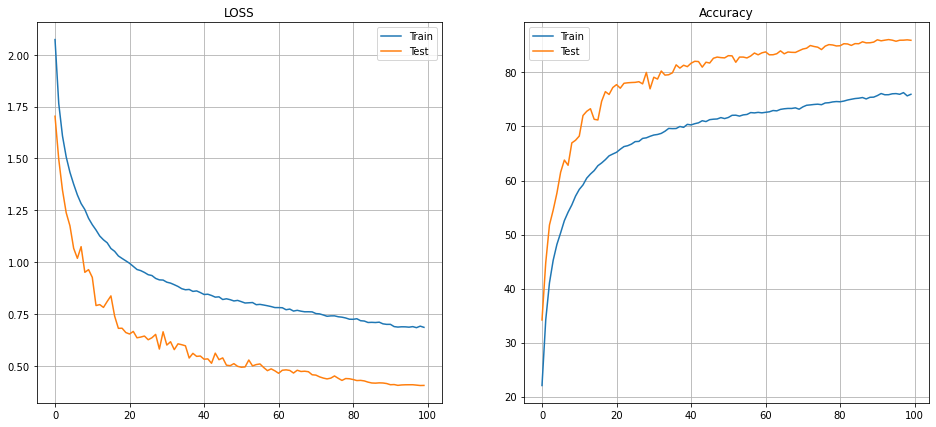

In [17]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history[1], label='Train')
axs[0].plot(history[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history[0], label='Train')
axs[1].plot(history[2], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()